**`Mechanical Model`**

To apply the Markov Chain Monte Carlo (MCMC) algorithm to a linear elastic mechanical model, we first need to define the model and the distribution of the parameters. In this case, we will assume that the Young's modulus E follows a normal distribution with mean 100 and standard deviation 10.

The linear elastic mechanical model can be described by the following equation:

σ = Eε

where E is the variable we are trying to identify.

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Text(0.5, 0, 'Strain')

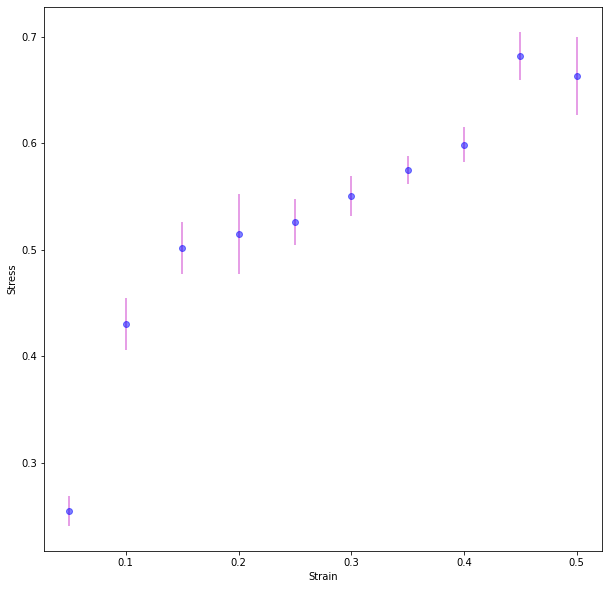

In [21]:
# Display Data
import numpy as np
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd

# Read the csv file using pandas
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/MDM project/MData.csv')

# Convert the dataframe to a 3D numpy array
array_3d = np.array([df.values.tolist()])
strain = array_3d[0,:,0]
stress = array_3d[0,:,1]
sd = array_3d[0,:,2]

import matplotlib.pyplot as plt
#Plot Strain-Stress Scatter Graph.
fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(1,1,1)
y = stress
x = strain
ax1.errorbar(x,y,yerr=sd, fmt='o', color='b', ecolor='m', alpha=0.5)
ax1.set_ylabel('Stress')
ax1.set_xlabel('Strain')

In [22]:
def likelihood(params, strain, stress, sd):
    E, sigma = params
    mu = 0
    log_likelihood = 0
    for i in range(len(strain)):
        log_likelihood += np.log(1 / (sd[i] * np.sqrt(2 * np.pi)) * np.exp(-(stress[i] - E * strain[i])**2 / (2 * sd[i]**2)))
    return log_likelihood

The prior distribution for the model parameters is simply the normal distribution we used to generate the values of E. 

N: The proposal_sd defines the "transition model" between current guess and new guess.

We can then define the MCMC algorithm using the Metropolis-Hastings algorithm:

In [23]:
def metropolis_hastings(n_iterations, initial_values, proposal_sds, strain, stress, sd):
    n_params = len(initial_values)
    samples = np.zeros((n_iterations, n_params))
    current_values = initial_values
    accepted = np.zeros(n_iterations)
    rejected = np.zeros(n_iterations)
    for i in range(n_iterations):
        # Propose new values
        proposal = current_values + np.random.normal(0, proposal_sds, n_params)
        # Calculate the acceptance ratio
        acceptance_ratio = min(1, np.exp(likelihood(proposal, strain, stress, sd) - likelihood(current_values, strain, stress, sd)))
        # Decide whether to accept or reject the proposal
        if np.random.rand() < acceptance_ratio:
            current_values = proposal
            accepted[i] = 1
        else:
            rejected[i] = 1
        samples[i] = current_values
    return samples, accepted, rejected

In [24]:
n_iterations = 1000
initial_values = [0.5, 0.01]
proposal_sds = [1, 0.1]

# Run MCMC algorithm
samples, accepted, rejected = metropolis_hastings(n_iterations, initial_values, proposal_sds, strain, stress, sd)

<ipython-input-22-56eae82aa93f>:6: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(1 / (sd[i] * np.sqrt(2 * np.pi)) * np.exp(-(stress[i] - E * strain[i])**2 / (2 * sd[i]**2)))
<ipython-input-23-2189f128dec7>:11: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = min(1, np.exp(likelihood(proposal, strain, stress, sd) - likelihood(current_values, strain, stress, sd)))


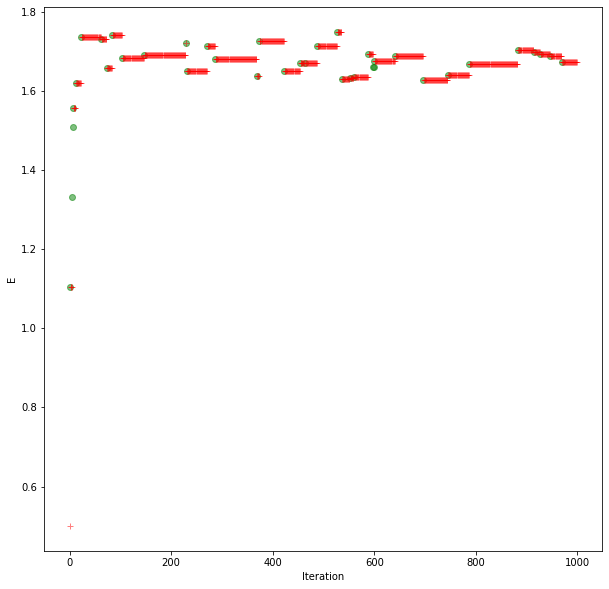

In [25]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
#ax.plot(np.arange(n_iterations), samples, alpha=0.5)
ax.plot(np.arange(n_iterations)[accepted==1], samples[accepted==1][:,0], 'go', alpha=0.5)
ax.plot(np.arange(n_iterations)[rejected==1], samples[rejected==1][:,0], 'r+', alpha=0.5)
ax.set_xlabel('Iteration')
ax.set_ylabel('E')
plt.show()

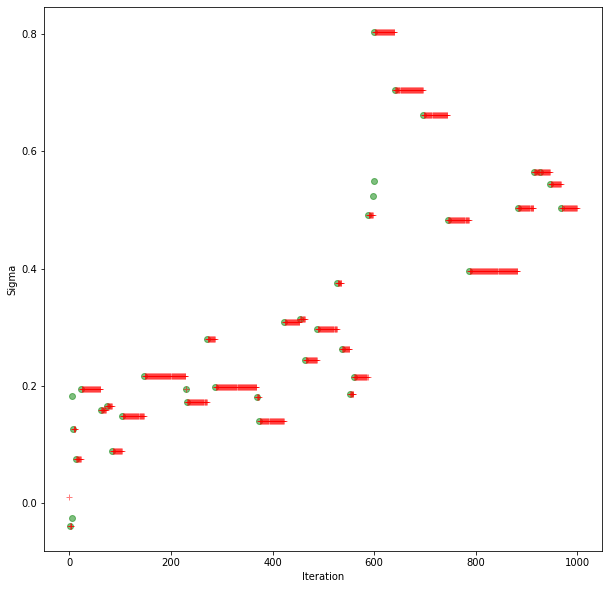

In [26]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
#ax.plot(np.arange(n_iterations), samples, alpha=0.5)
ax.plot(np.arange(n_iterations)[accepted==1], samples[accepted==1][:,1], 'go', alpha=0.5)
ax.plot(np.arange(n_iterations)[rejected==1], samples[rejected==1][:,1], 'r+', alpha=0.5)
ax.set_xlabel('Iteration')
ax.set_ylabel('Sigma')
plt.show()

1.6723644493452412 0.5036654499559609


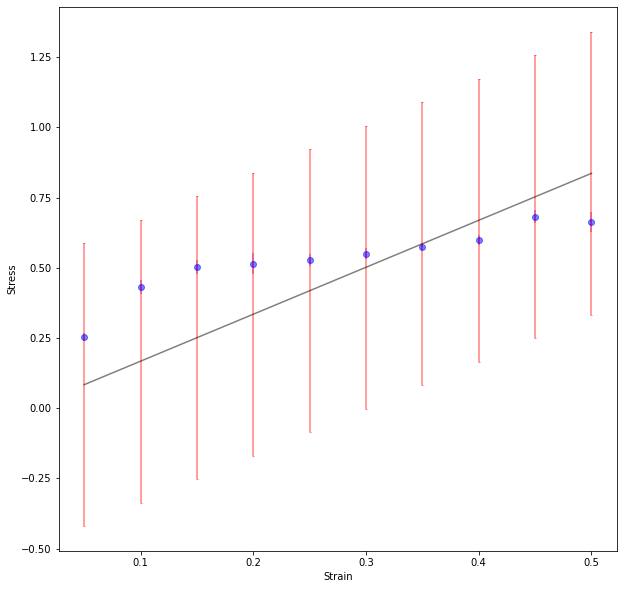

In [27]:
fig1 = plt.figure(figsize=(10,10))
ax1 = fig1.add_subplot(1,1,1)
y = stress
x = strain
# Plot the trace of the parameters
E, sigma = samples[accepted==1][-1]
y2 = strain*E
ax1.errorbar(x,y,yerr=sd, fmt='o', color='b', ecolor='m', alpha=0.5)
ax1.errorbar(strain, y2, yerr=sigma, fmt='-',color='k', ecolor='red', capsize=1, alpha=0.5)
ax1.set_ylabel('Stress')
ax1.set_xlabel('Strain')
print(E,sigma)